In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import sparse
import scipy.sparse.linalg
from pyunlocbox import functions, solvers

import networkx as nx

In [158]:
routenames = ['Airline', 'Airline_ID', 'Src_IATA', 'Src_ID', 
            'Des_IATA', 'Des_ID', 'Codeshare', 'Stops', 'Equipment']

routes = pd.read_csv("routes.dat",header = None,names = routenames,encoding = 'utf-8', na_values='\\N')
routes.dropna(subset=["Airline_ID"], inplace=True)

airlines = pd.read_csv("airlines.dat",names = ['Airline_ID','Name','Alias','IATA','ICAO','Callsign','Country','Active'])

airports = pd.read_csv("airports.dat",names = ['Airport_ID','Name','City','Country','IATA','ICAO','Latitude','Longitude',
                                               'Altitude','Timezone','DST','TZ database','Type','Source'], na_values='\\N')

In [3]:
routes.head(5)

,Airline,Airline_ID,Src_IATA,Src_ID,Des_IATA,Des_ID,Codeshare,Stops,Equipment
0,2B,410.0,AER,2965.0,KZN,2990.0,NaN,0,CR2
1,2B,410.0,ASF,2966.0,KZN,2990.0,NaN,0,CR2
2,2B,410.0,ASF,2966.0,MRV,2962.0,NaN,0,CR2
3,2B,410.0,CEK,2968.0,KZN,2990.0,NaN,0,CR2
4,2B,410.0,CEK,2968.0,OVB,4078.0,NaN,0,CR2


In [160]:
airports.head(5)

,Airport_ID,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,TZ database,Type,Source
0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10.0,U,Pacific/Port_Moresby,airport,OurAirports
1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001,20,10.0,U,Pacific/Port_Moresby,airport,OurAirports
2,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388,10.0,U,Pacific/Port_Moresby,airport,OurAirports
3,4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10.0,U,Pacific/Port_Moresby,airport,OurAirports
4,5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001,146,10.0,U,Pacific/Port_Moresby,airport,OurAirports


In [127]:
route_active = pd.merge(routes,airlines[['Airline_ID','Active']].copy().drop_duplicates('Airline_ID'))
route_active = route_active.loc[(route_active.Active=='Y')].copy()
route_active.drop(columns=['Airline','Airline_ID','Codeshare','Active'],inplace=True)
route_active.head()

,Src_IATA,Src_ID,Des_IATA,Des_ID,Stops,Equipment
0,AER,2965.0,KZN,2990.0,0,CR2
1,ASF,2966.0,KZN,2990.0,0,CR2
2,ASF,2966.0,MRV,2962.0,0,CR2
3,CEK,2968.0,KZN,2990.0,0,CR2
4,CEK,2968.0,OVB,4078.0,0,CR2


In [191]:
route_active.Equipment.value_counts()

320                        9111
738                        7124
319                        3412
737                        2201
73H                        2043
CRJ                        1238
73W                        1155
321                        1146
AT7                        1118
E90                        1049
320 319                     904
319 320                     904
333                         886
DH4                         866
332                         756
763                         692
777                         617
73G                         571
DH8                         537
330                         525
ERJ                         505
ATR                         504
77W                         502
733                         458
SF3                         433
CR7                         424
757                         420
ER4                         396
320 321                     377
321 320                     366
                           ... 
M88 CRJ 

In [128]:
portgeo = pd.DataFrame(pd.concat([routes.Src_ID,routes.Des_ID],axis=0).drop_duplicates())
portgeo.rename(columns={0:'Airport_ID'},inplace=True)
portgeo.reset_index(level=0, drop=True,inplace=True)
portgeo.head(5)

,Airport_ID
0,2965.0
1,2966.0
2,2968.0
3,4029.0
4,6156.0


In [130]:
portgeo = portgeo.merge(airports[['Name','City','Country','IATA','Latitude','Longitude','Airport_ID']],on='Airport_ID')
portgeo.reset_index(level=0, inplace=True)
portgeo.rename(columns={'index':'node_idx'},inplace=True)
portgeo.head(5)

,node_idx,Airport_ID,Name,City,Country,IATA,Latitude,Longitude
0,0,2965.0,Sochi International Airport,Sochi,Russia,AER,43.449902,39.956600
1,1,2966.0,Astrakhan Airport,Astrakhan,Russia,ASF,46.283298,48.006302
2,2,2968.0,Chelyabinsk Balandino Airport,Chelyabinsk,Russia,CEK,55.305801,61.503300
3,3,4029.0,Domodedovo International Airport,Moscow,Russia,DME,55.408798,37.906300
4,4,6156.0,Belgorod International Airport,Belgorod,Russia,EGO,50.643799,36.590099


In [133]:
adj = np.zeros((len(portgeo),len(portgeo)))
cnt = 0
for i in range(len(route_active)):
    src_ID = route_active.iloc[i].Src_ID
    des_ID = route_active.iloc[i].Des_ID
    src_IATA = route_active.iloc[i].Src_IATA
    des_IATA = route_active.iloc[i].Des_IATA
    if (src_ID in portgeo.Airport_ID.get_values()) & (des_ID in portgeo.Airport_ID.get_values()):
        src_idx = portgeo.loc[portgeo.Airport_ID==src_ID].node_idx.get_values()[0]
        des_idx = portgeo.loc[portgeo.Airport_ID==des_ID].node_idx.get_values()[0]
        adj[src_idx][des_idx] +=1
    else: 
        cnt +=1
        print(cnt,src_IATA,des_IATA)

1 DME TGK
2 TGK DME
3 ADQ AOS
4 ADQ KKB
5 ADQ KOZ
6 ADQ OLH
7 AOS KZB
8 KKB SYB
9 KOZ ORI
10 SYB KPR
11 CGA HYL
12 CGA KTN
13 HYL CGA
14 HYL KTB
15 HYL KTN
16 KTB HYL
17 KTB KTN
18 KTN CGA
19 KTN HYL
20 KTN KTB
21 CKG PZI
22 CTU JIQ
23 CTU PZI
24 JIQ CTU
25 NTG WUH
26 PZI CKG
27 PZI CTU
28 TVS TYN
29 TYN TVS
30 WUH NTG
31 MEX PQM
32 PQM MEX
33 CPT PBZ
34 ELL JNB
35 JNB ELL
36 PBZ CPT
37 PBZ JNB
38 AMD HYD
39 BBI HYD
40 BLR HYD
41 BOM HYD
42 CCU HYD
43 COK HYD
44 DEL HYD
45 DXB HYD
46 GOI HYD
47 HYD AMD
48 HYD BBI
49 HYD BLR
50 HYD BOM
51 HYD CCU
52 HYD COK
53 HYD DEL
54 HYD DXB
55 HYD GOI
56 HYD JAI
57 HYD MAA
58 HYD PNQ
59 HYD RPR
60 HYD VTZ
61 JAI HYD
62 MAA HYD
63 PNQ HYD
64 RPR HYD
65 VTZ HYD
66 AKI KKI
67 AKI TLT
68 ANI CHU
69 ANV KGX
70 ATT BET
71 AUK SXP
72 BET PQS
73 BET TLT
74 BET WTL
75 CHU CKD
76 CKD RDV
77 CKD SLQ
78 KGX ANV
79 KGX SHX
80 KKI AKI
81 KKI KWT
82 KOT WBB
83 KSM SXP
84 KUK NUP
85 KWT KKI
86 MOU PQS
87 NME TNK
88 NUP ATT
89 OME WBB
90 OOK TNK
91 OTZ PHO
92 PHO O

695 GDN LUZ
696 LUZ GDN
697 LUZ MXP
698 MXP LUZ
699 AMS DOH
700 DOH AMS
701 DOH MCT
702 MCT DOH
703 FUO NAY
704 JGN JIC
705 JIC JGN
706 JIC NAY
707 JUH NAY
708 NAY FUO
709 NAY JIC
710 NAY JUH
711 DOH KWI
712 KWI DOH
713 CKG NTG
714 NTG CKG
715 BZV OLL
716 OLL BZV
717 DJE NBE
718 NBE LUX
719 BAH DOH
720 DOH BAH
721 DOH FRA
722 FRA DOH
723 BEN MRA
724 CAI MRA
725 HBE MRA
726 MRA BEN
727 MRA CAI
728 MRA HBE
729 MRA SFA
730 MRA TUN
731 QUB TIP
732 SFA MRA
733 TIP QUB
734 TUN MRA
735 BAH DOH
736 DOH BAH
737 DOH FRA
738 FRA DOH
739 DHB RCE
740 DHB WSX
741 FBS LKE
742 FBS RCE
743 LKE FBS
744 LKE SEA
745 LKE YWH
746 LPS WSX
747 RCE DHB
748 RCE FBS
749 WSX DHB
750 WSX LPS
751 YWH LKE
752 BEY DOH
753 DOH BEY
754 JUH XMN
755 XMN JUH
756 DOH KUL
757 DOH RUH
758 HYD KUL
759 KCH TGC
760 KUL DOH
761 KUL HYD
762 LBP MUR
763 MUR LBP
764 RUH DOH
765 TGC KCH
766 HYD SIN
767 SIN HYD
768 ULN ULZ
769 ULZ ULN
770 CAI DOH
771 DOH CAI
772 BSD KMG
773 CAN HIA
774 DDG TAO
775 DQA TAO
776 FSZ PVG
777 FUO NAY
778 

1351 MUC DOH
1352 CBS CCS
1353 CCS CBS
1354 FCO LUZ
1355 LUZ FCO
1356 HAN VDH
1357 SGN THD
1358 SGN VDH
1359 THD SGN
1360 VDH HAN
1361 VDH SGN
1362 KHZ KXU
1363 KXU PPT
1364 PPT RKA
1365 RKA KHZ
1366 ABB ABV
1367 ABB LOS
1368 ABV ABB
1369 ABV GMO
1370 ABV QRW
1371 GMO ABV
1372 LOS ABB
1373 LOS QRW
1374 QRW ABV
1375 QRW LOS
1376 JAU LIM
1377 LIM JAU
1378 BEG MLH
1379 GSE TZL
1380 LTN LUZ
1381 LUZ LTN
1382 LUZ TRF
1383 MLH BEG
1384 MLH SKP
1385 MLH TZL
1386 MMX TZL
1387 SKP MLH
1388 TRF LUZ
1389 TZL GSE
1390 TZL MLH
1391 TZL MMX
1392 BGO FDE
1393 FDE BGO
1394 FDE OSL
1395 FRO FDE
1396 OSL FDE
1397 YDP YNP
1398 YHO YNP
1399 YHR ZGS
1400 YNA ZGS
1401 YNP YDP
1402 YNP YHO
1403 YZV ZGS
1404 ZGS YHR
1405 ZGS YNA
1406 ZGS YZV
1407 ZGS ZKG
1408 ZKG ZGS
1409 BKG DAL
1410 BKG HOU
1411 BKG MDW
1412 DAL BKG
1413 HOU BKG
1414 MDW BKG
1415 DOH BAH
1416 DOH MCT
1417 HYD MCT
1418 MCT DOH
1419 MCT HYD
1420 KJA TGP
1421 KJA THX
1422 TGP KJA
1423 THX KJA
1424 DXB GSM
1425 GSM DXB
1426 MCM NCE
1427 NCE MCM

In [157]:
cnt/i

0.022402646218613743

2.2% flights cannot find the longitude or latitude of their source or destination airport.

In [161]:
np.save('weighted_adj', adj)

## Load the graph

In [137]:
G=nx.from_numpy_array(adj)

In [138]:
# GC = max(nx.connected_component_subgraphs(G), key=len)

In [186]:
n_nodes = len(G)
n_degree = np.sum(adj,axis=1)
idx_hub = np.where(n_degree>500)

In [188]:
portgeo.loc[idx_hub]

,node_idx,Airport_ID,Name,City,Country,IATA,Latitude,Longitude
117,117,3830.0,Chicago O'Hare International Airport,Chicago,United States,ORD,41.978600,-87.904800
164,164,3682.0,Hartsfield Jackson Atlanta International Airport,Atlanta,United States,ATL,33.636700,-84.428101
271,271,3364.0,Beijing Capital International Airport,Beijing,China,PEK,40.080101,116.584999
402,402,1382.0,Charles de Gaulle International Airport,Paris,France,CDG,49.012798,2.550000
428,428,507.0,London Heathrow Airport,London,United Kingdom,LHR,51.470600,-0.461941


In [143]:
def G_pos(x,y,n_nodes): # function to return the position(latitiude and longtitude) of  each node (for plot)
    pos_dic = {}
    for i in range(n_nodes):
        pos_dic[i] = x[i],y[i]
    return pos_dic

In [147]:
longitude = portgeo.Longitude.get_values()
latitude = portgeo.Latitude.get_values()

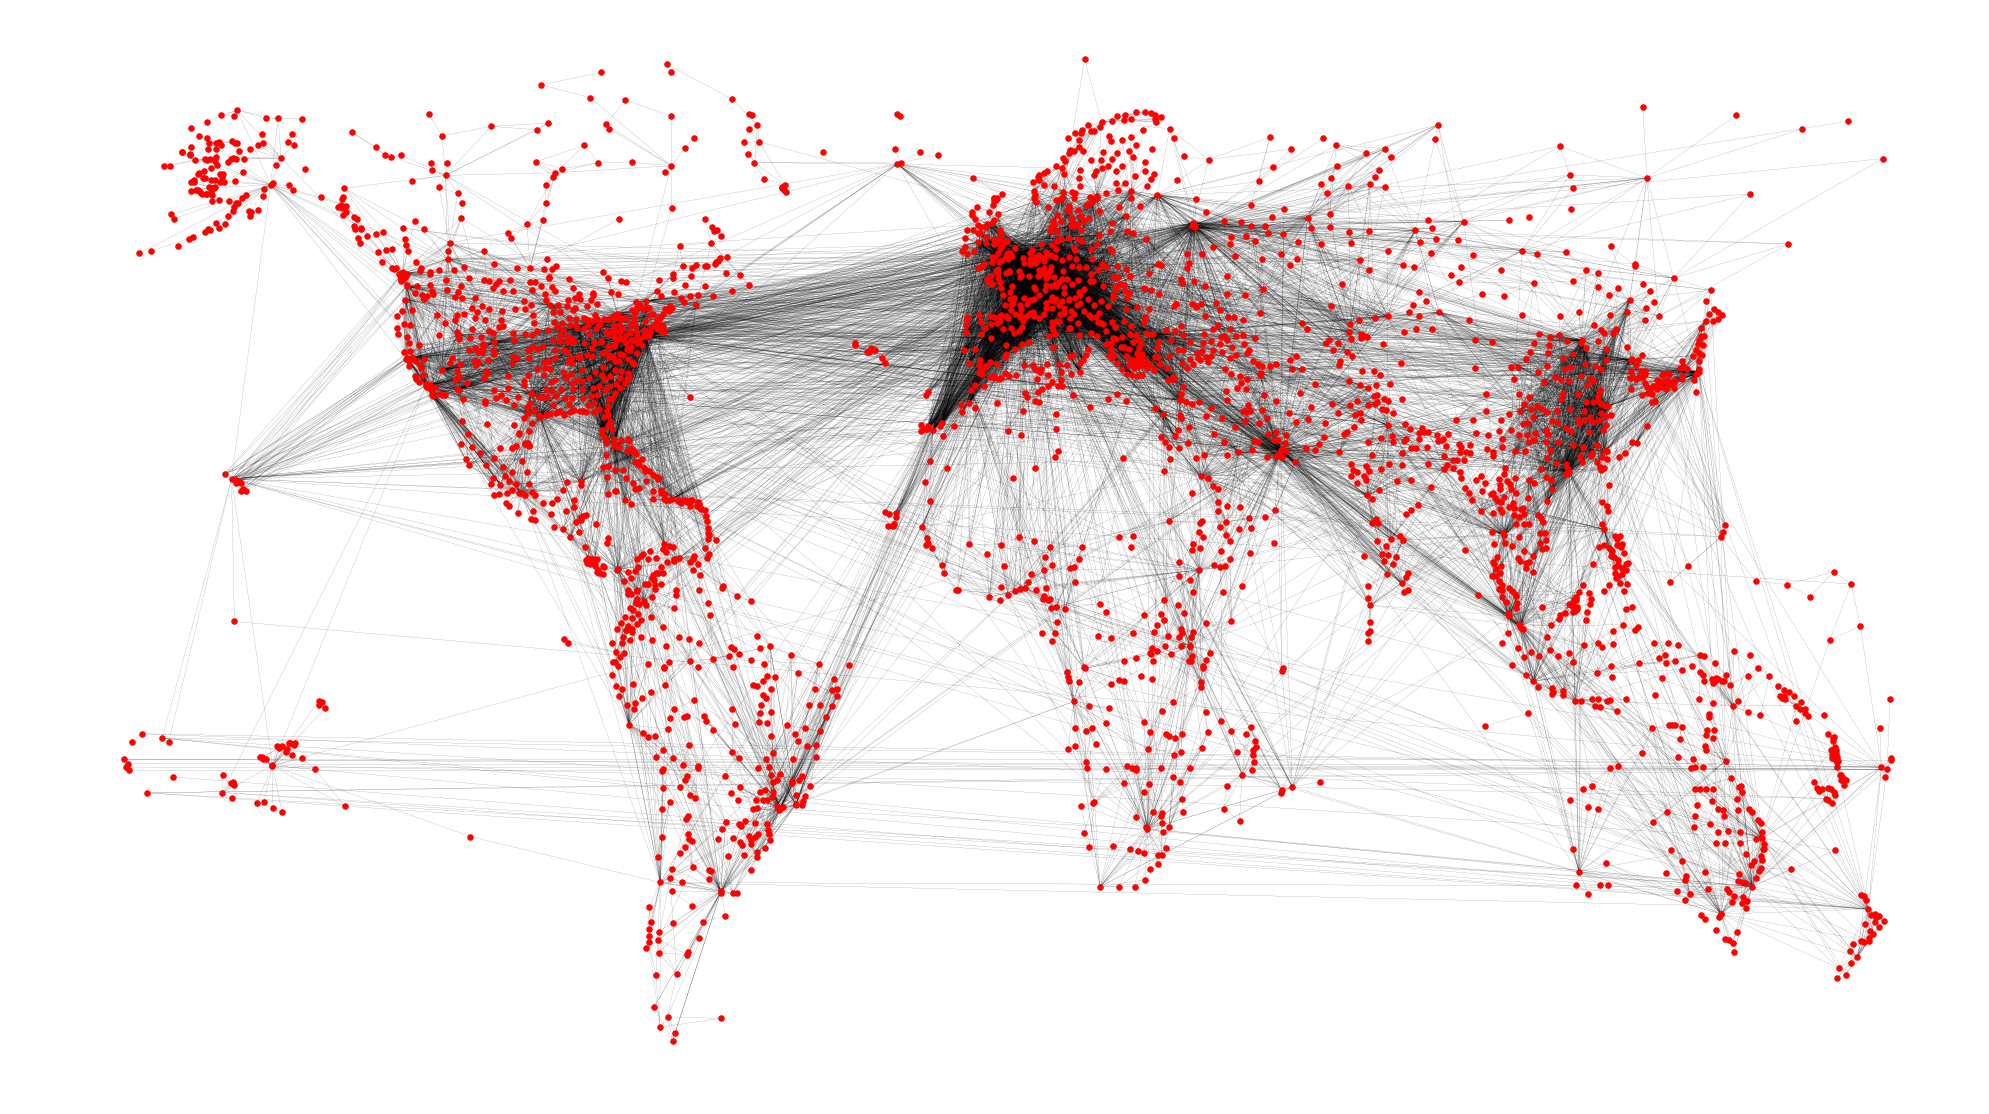

In [154]:
pos = G_pos(x=longitude,y=latitude,n_nodes=n_nodes) # return the positions (latitiude and longtitude) of all nodes
plt.figure(figsize=(15*1.8,15))

nx.draw(G, pos=pos,node_size=30,width=0.1,cmap='RdYlBu')